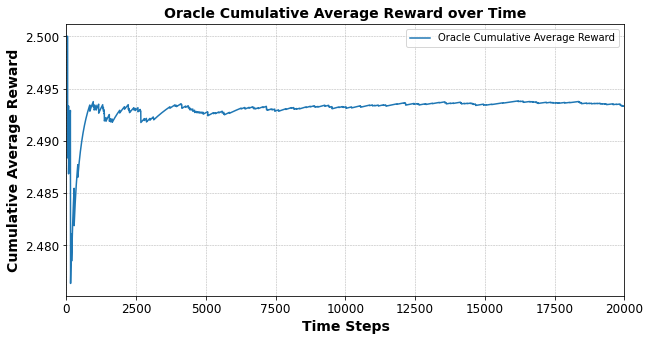

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
#pivot_df = pd.read_csv('synthetic_scenario_three.csv')
#pivot_df = pd.read_csv('synthetic_scenario_two.csv')
#pivot_df = pd.read_csv('synthetic_scenario_alternating.csv')
#pivot_df = pd.read_csv('synthetic_scenario_one.csv')
#pivot_df = pd.read_csv('synthetic_scenario_temp_one_20k.csv')
#pivot_df = pd.read_csv('synthetic_scenario_temp.csv')
#"synthetic_scenario_30_nodes.csv"
pivot_df = pd.read_csv("synthetic_scenario_30_nodes.csv")
pivot_df = pivot_df.apply(lambda x: x.fillna(x.mean()), axis=0)
pivot_df = pivot_df.head(20000)

# Parameters
reward = 0.5
M = 5 # Maximum number of nodes that can be polled
theta = 0.5  # Threshold for reward condition
penalty = -0.5  # Penalty for polling when difference is <= theta
aoii_penalty = 0.5
initial_value = 20  # Initial estimate for last polled values

# Initialize last polled values
last_polled_values = {f'mote{i}': initial_value for i in range(1, 31)}

def run_oracle_simulation(M):
    last_update_times = {f'mote{i}': 0 for i in range(1, 31)}
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    valuable_sensor_data = []

    for t in range(len(pivot_df)):  # Loop over each time step
        current_time_step = t
        rewards = {}

        # Calculate rewards for each mote
        for mote in last_update_times:
            current_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Reward is the difference between the current and last value
            rewards[mote] = abs(current_value - last_value)

        # Filter nodes with rewards greater than the threshold
        eligible_nodes = {mote: reward for mote, reward in rewards.items() if reward > theta}

        # Select the top M nodes among eligible nodes
        top_m_nodes = sorted(eligible_nodes, key=eligible_nodes.get, reverse=True)[:M]

        total_reward_for_round = 0

        # Process the selected nodes
        for mote in top_m_nodes:
            measured_value = pivot_df.loc[current_time_step, mote]
            last_value = last_polled_values[mote]

            # Calculate reward
            total_reward_for_round += reward # Reward (since all polled nodes have value > theta)

            # Update last polled value and time
            last_update_times[mote] = current_time_step
            last_polled_values[mote] = measured_value

            # Store valuable sensor data
            valuable_sensor_data.append({
                'index': current_time_step,
                'selected_moteid': mote,
                'temperature': measured_value,
                'predicted_temperature': measured_value,  # Oracle knows the true value
                'time_elapsed': current_time_step - last_update_times[mote]
            })

        # Update cumulative reward
        cumulative_reward += total_reward_for_round
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    return cumulative_rewards, valuable_sensor_df

# Run simulation for the given value of M
cumulative_rewards_oracle, valuable_sensor_df = run_oracle_simulation(M)

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_oracle, columns=["cumulative_reward"]).to_csv('cumulative_rewards_oracle.csv', index=False)

# Plot cumulative average reward over time for Oracle
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_oracle) + 1), cumulative_rewards_oracle, label='Oracle Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Oracle Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(cumulative_rewards_oracle))

# Save the plot
plt.savefig('oracle_cumulative_average_reward.png')

plt.show()


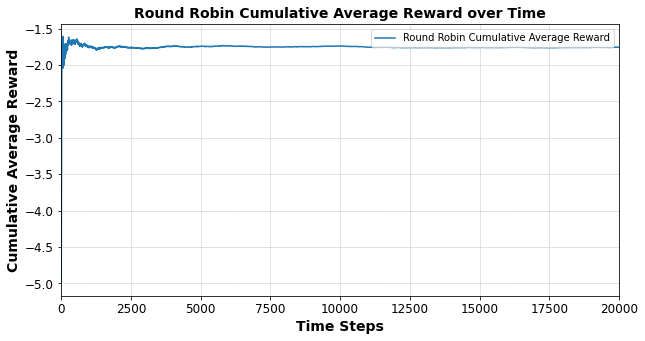

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Parameters
columns = pivot_df.columns  # Get the actual column names from the dataset
num_nodes = 30  # Total number of nodes based on columns in the dataset # Maximum number of nodes to poll in each time step
#theta = 0.5  # Threshold for significant difference
 # Penalty for insignificant difference
initial_value = 20  # Initial value for last polled
num_time_steps = len(pivot_df)  # Total time steps based on the dataset

# Initialize last polled values
last_polled_values_rr = {column: initial_value for column in columns}

def run_simulation_round_robin(pivot_df, columns, M, theta, penalty):
    last_polled_values = {column: initial_value for column in columns}  # Last polled values
    cumulative_reward = 0  # Total cumulative reward
    cumulative_rewards = []  # Store cumulative rewards over time

    for t in range(len(pivot_df)):  # Loop over all time steps
        # Poll M nodes in cyclic order
        nodes_rr = [columns[(t + i) % num_nodes] for i in range(M)]  # Poll M nodes in cyclic order
        round_reward = 0  # Reward for the current time step

        for node_rr in nodes_rr:
            current_value = pivot_df.loc[t, node_rr]  # Current value for the node
            last_value = last_polled_values[node_rr]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward  # Reward
            else:
                round_reward += penalty  # Penalty

            # Update the last polled value
            last_polled_values[node_rr] = current_value

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Append cumulative average reward

    return cumulative_rewards

# Run Round Robin simulation with perfect transmission
cumulative_rewards_rr = run_simulation_round_robin(pivot_df, columns, M, theta, penalty)

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_rr, columns=["cumulative_reward"]).to_csv('cumulative_rewards_round_robin.csv', index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_rr) + 1), cumulative_rewards_rr, label='Round Robin Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Round Robin Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(cumulative_rewards_rr))

# Save the plot
plt.savefig('round_robin_cumulative_average_reward.png')

plt.show()

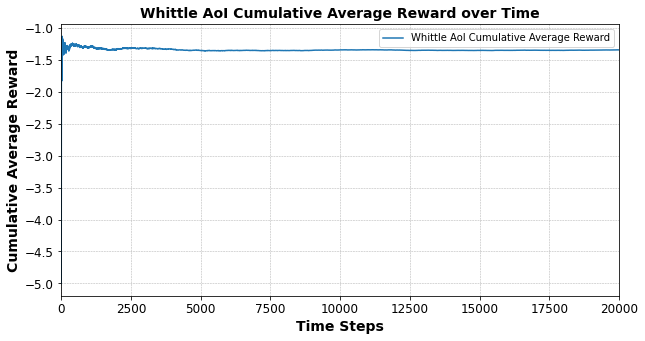

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_nodes = len(pivot_df.columns)  # Ensure we only consider available nodes
 # Number of nodes to poll
#theta = 0.5  # Threshold for node transmission
#penalty = -0.1  # Penalty for polling when the condition is not met

def run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty):
    """Simulate Whittle Index-based polling strategy for AoI."""
    cumulative_reward = 0
    cumulative_rewards = []
    last_update_whittle = np.zeros(num_nodes)  # Track last update times
    last_polled_values = {col: 20.0 for col in pivot_df.columns}  # Initialize last polled values

    for t in range(len(pivot_df)):  # Iterate over all time steps
        whittle_indices = {}

        # Compute Whittle indices for each node
        for node in range(num_nodes):  # Now using 0-based index
            column_name = pivot_df.columns[node]  # Get column directly
            
            delta_t_dynamic = t - last_update_whittle[node]  # Time since last update
            current_aoi = delta_t_dynamic
            future_aoi_passive = delta_t_dynamic + penalty
            future_aoi_active = 0  # Assuming perfect transmission

            q_passive = current_aoi + future_aoi_passive
            q_active = current_aoi + future_aoi_active + penalty  # No additional penalty for active action
            whittle_indices[node] = q_passive - q_active

        # Step 2: Select top M nodes
        nodes_to_poll = [node for node, index in whittle_indices.items() if index >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=lambda node: whittle_indices[node], reverse=True)[:M]

        round_reward = 0  # Reward for the current time step

        # Step 3: Poll selected nodes
        for node in nodes_to_poll:
            column_name = pivot_df.columns[node]  # Get the column name
            
            current_value = pivot_df.loc[t, column_name]
            last_value = last_polled_values[column_name]

            # Calculate reward or penalty
            if abs(current_value - last_value) > theta:
                round_reward += reward # Reward
            else:
                round_reward += penalty  # Penalty

            # Update last polled values
            last_polled_values[column_name] = current_value
            last_update_whittle[node] = t  # Update last update time

        # Update cumulative reward
        cumulative_reward += round_reward
        cumulative_rewards.append(cumulative_reward / (t + 1))  # Compute cumulative average reward

    return cumulative_rewards

# Run the simulation
cumulative_rewards_whittle = run_simulation_whittle_aoi(pivot_df, num_nodes, M, theta, penalty)

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle_aoi.csv', index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoI Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle AoI Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig('whittle_aoi_cumulative_average_reward.png')
plt.show()



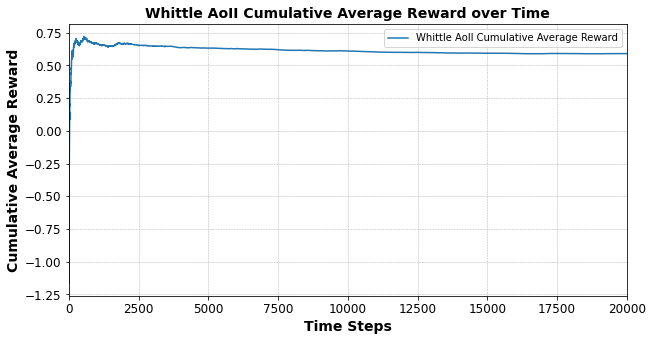

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
#penalty = -1  # Penalty for polling when difference <= theta
#aoii_penalty = 1
#theta = 0.5  # Threshold for reward
beta_1 = 0.99  # dEWMA parameter for state value
beta_2 = 0.99 # dEWMA parameter for rate of change
columns = pivot_df.columns  # Get the column names dynamically
num_nodes = len(columns)  # Number of nodes based on dataset columns
num_time_steps = len(pivot_df)  # Total time steps based on dataset length


# Function to calculate Age of Incorrect Information (AoII) at the sink
def calculate_aoii_sink(current_time, last_received_time, last_rate_of_change):
    return abs((current_time - last_received_time) * last_rate_of_change)

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# Helper function to calculate reward
def calculate_reward(measured_value, last_state_value, theta, penalty):
    if abs(measured_value - last_state_value) > theta:
        return reward # Reward
    return penalty  # Penalty

# Main function to simulate Whittle AoII with rewards
def run_simulation_whittle_aoii(pivot_df, columns, M, theta, penalty, aoii_penalty):
    cumulative_reward = 0  # Track total cumulative reward
    cumulative_rewards = []  # Store cumulative average reward over time
    last_update_times = {col: 0 for col in columns}  # Last update time for each node
    state_node = {col: np.array([20.0, 0.1]) for col in columns}  # Node states

    for t in range(len(pivot_df)):
        # Step 1: Compute Whittle indices for each node based on AoII
        whittle_indices = {}
        for col in columns:
            #delta_t_dynamic = t - last_update_times[col]  # Time since last update
            last_state_value, last_rate_of_change = state_node[col]
            measured_value = pivot_df.loc[t, col]

            # Correct AoII calculation at the sink using rate of change
            current_aoii = calculate_aoii_sink(t, last_update_times[col], last_rate_of_change)
            future_aoii_passive = calculate_aoii_sink(t+1, last_update_times[col], last_rate_of_change)  # Updated AoII increase assumption for passive
            future_aoii_active = 0  # AoII resets to 0 if polled

            # Whittle index calculations
            q_passive = current_aoii + future_aoii_passive
            q_active = current_aoii + future_aoii_active + aoii_penalty
            whittle_indices[col] = q_passive - q_active

        # Step 2: Select top M nodes to poll based on Whittle indices
        nodes_to_poll = [col for col in whittle_indices if whittle_indices[col] >= 0]
        if len(nodes_to_poll) > M:
            nodes_to_poll = sorted(nodes_to_poll, key=whittle_indices.get, reverse=True)[:M]

        # Step 3: Poll selected nodes and calculate rewards
        for col in nodes_to_poll:
            measured_value = pivot_df.loc[t, col]
            last_state_value, last_rate_of_change = state_node[col]

            # Calculate reward after polling
            reward = calculate_reward(measured_value, last_state_value, theta, penalty)
            cumulative_reward += reward  # Update cumulative reward

            delta_t_dynamic = t - last_update_times[col]  # Time since last update

            # Update node state and last update time
            state_node[col] = update_node_state_dewma(
                measured_value, last_state_value, last_rate_of_change, delta_t_dynamic, beta_1=beta_1, beta_2=beta_2
            )
            last_update_times[col] = t

        # Step 4: Calculate cumulative average reward
        cumulative_rewards.append(cumulative_reward / (t + 1))

    return cumulative_rewards

# Run the simulation
cumulative_rewards_whittle = run_simulation_whittle_aoii(pivot_df, columns, M, theta, penalty, aoii_penalty)

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_whittle, columns=["cumulative_reward"]).to_csv('cumulative_rewards_whittle_aoii.csv', index=False)

# Plot cumulative average reward over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_whittle) + 1), cumulative_rewards_whittle, label='Whittle AoII Cumulative Average Reward')
plt.xlabel('Time Steps', fontsize=14, fontweight='bold')
plt.ylabel('Cumulative Average Reward', fontsize=14, fontweight='bold')
plt.title('Whittle AoII Cumulative Average Reward over Time', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, len(cumulative_rewards_whittle))

# Save the plot
plt.savefig('whittle_aoii_cumulative_average_reward.png')

plt.show()


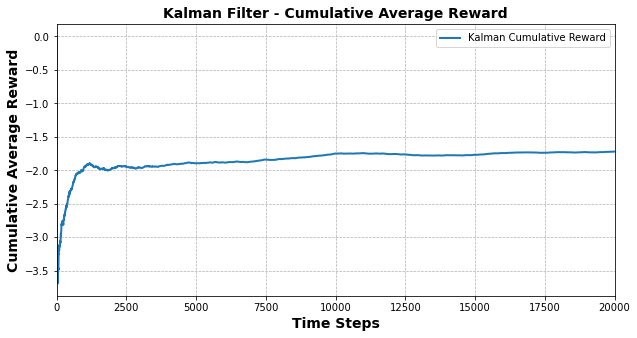

Final Cumulative Average Reward: -1.7204


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error



# Parameters
num_nodes = 30  # Number of nodes
#theta = 0.1  # Threshold for node transmission
# Number of nodes to poll at each time step
#penalty = -0.1  # Penalty when the condition is not met

# Initialize state vectors and covariance matrices
x_hat_node = {f'mote{i}': np.array([20.0, 0.1]) for i in range(1, num_nodes + 1)}
P_node = {f'mote{i}': np.eye(2) for i in range(1, num_nodes + 1)}
x_hat_sink = {f'mote{i}': np.array([20.0, 0.1]) for i in range(1, num_nodes + 1)}

# Track last update times
last_update_times = {i: 0 for i in range(1, num_nodes + 1)}

# Kalman filter matrices
A_node = np.array([[1, 1],  # State transition matrix
                   [0, 1]])
Q_node = np.array([[0.01, 0],  # Process noise covariance
                   [0, 0.01]])
H_node = np.array([[1, 0]])  # Observation matrix
R = np.array([[0.1]])  # Measurement noise covariance

# Kalman filter function for nodes
def kalman_node(measured_value, x_hat, P):
    xp = A_node @ x_hat
    Pp = A_node @ P @ A_node.T + Q_node
    K = Pp @ H_node.T @ np.linalg.inv(H_node @ Pp @ H_node.T + R)
    x_hat = xp + K @ (measured_value - H_node @ xp)
    P = Pp - K @ H_node @ Pp
    return x_hat, P

# Predict node state from sink
def predict_node_state_from_sink(x_hat, delta_t_dynamic):
    predicted_value = x_hat[0] + x_hat[1] * delta_t_dynamic
    return np.array([predicted_value, x_hat[1]])

# Polling function
def poll_nodes(pivot_df, current_time, x_hat_node, x_hat_sink, P_node, M, cumulative_reward):
    exceedance_values = {}

    # Step 1: Predict sink values and check if threshold is exceeded
    for mote in range(1, num_nodes + 1):
        column_name = f'mote{mote}'
        last_update_time = last_update_times[mote]
        delta_t_dynamic = current_time+1 - last_update_time

        predicted_value = predict_node_state_from_sink(x_hat_sink[column_name], delta_t_dynamic)[0]
        if abs(predicted_value - x_hat_sink[column_name][0]) > theta:
            exceedance_values[mote] = abs(predicted_value - x_hat_sink[column_name][0])

    # Step 2: Select top M nodes
    nodes_to_poll = sorted(exceedance_values, key=exceedance_values.get, reverse=True)[:M]

    # Step 3: Poll selected nodes
    for mote in nodes_to_poll:
        column_name = f'mote{mote}'
        measured_value = pivot_df.loc[current_time, column_name]

        # Node Kalman filtering
        x_hat_node[column_name], P_node[column_name] = kalman_node(measured_value, x_hat_node[column_name], P_node[column_name])
        x_hat_sink[column_name] = x_hat_node[column_name]  # Update sink state

        last_update_times[mote] = current_time

        # Step 4: Compute reward
        if abs(measured_value - x_hat_sink[column_name][0]) > theta:
            cumulative_reward += reward  # Reward
        else:
            cumulative_reward += penalty  # Penalty

    return x_hat_node, x_hat_sink, P_node, cumulative_reward

# Initialize cumulative reward tracking
cumulative_reward = 0  # Single cumulative reward for all nodes
cumulative_rewards_over_time = []  # To track cumulative average reward over time

# Simulation settings
num_steps = len(pivot_df)

# Run the simulation
for t in range(num_steps):
    x_hat_node, x_hat_sink, P_node, cumulative_reward = poll_nodes(
        pivot_df, t, x_hat_node, x_hat_sink, P_node, M, cumulative_reward
    )
    
    # Compute cumulative average reward
    avg_reward = cumulative_reward / (t + 1)
    cumulative_rewards_over_time.append(avg_reward)

# Save cumulative rewards to CSV
pd.DataFrame(cumulative_rewards_over_time, columns=["cumulative_reward"]).to_csv("cumulative_rewards_kalman.csv", index=False)

# Plot cumulative average reward
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_rewards_over_time) + 1), cumulative_rewards_over_time, label='Kalman Cumulative Reward', linewidth=2)
plt.xlabel("Time Steps", fontsize=14, fontweight="bold")
plt.ylabel("Cumulative Average Reward", fontsize=14, fontweight="bold")
plt.title("Kalman Filter - Cumulative Average Reward", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.7)
plt.xlim(0, len(cumulative_rewards_over_time))
plt.savefig("kalman_cumulative_average_reward.png")
plt.show()

# Print final cumulative reward statistics
print(f"Final Cumulative Average Reward: {cumulative_rewards_over_time[-1]:.4f}")



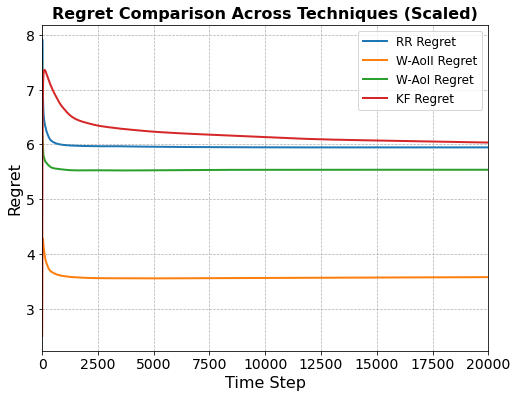

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scaling factor
#scaling_factor = 1.5

# Load cumulative rewards from CSV files
cumulative_rewards_oracle = pd.read_csv('cumulative_rewards_oracle.csv')['cumulative_reward'].values #
cumulative_rewards_rr = pd.read_csv('cumulative_rewards_round_robin.csv')['cumulative_reward'].values #
cumulative_rewards_whittle_aoii = pd.read_csv('cumulative_rewards_whittle_aoii.csv')['cumulative_reward'].values #
cumulative_rewards_whittle_aoi = pd.read_csv('cumulative_rewards_whittle_aoi.csv')['cumulative_reward'].values #
cumulative_rewards_kalman = pd.read_csv('cumulative_rewards_kalman.csv')['cumulative_reward'].values #

# Calculate cumulative average rewards for each technique
cumulative_average_reward_oracle = np.cumsum(cumulative_rewards_oracle) / (np.arange(len(cumulative_rewards_oracle)) + 1)
cumulative_average_reward_rr = np.cumsum(cumulative_rewards_rr) / (np.arange(len(cumulative_rewards_rr)) + 1)
cumulative_average_reward_waoii = np.cumsum(cumulative_rewards_whittle_aoii) / (np.arange(len(cumulative_rewards_whittle_aoii)) + 1)
cumulative_average_reward_waoi = np.cumsum(cumulative_rewards_whittle_aoi) / (np.arange(len(cumulative_rewards_whittle_aoi)) + 1)
cumulative_average_reward_kalman = np.cumsum(cumulative_rewards_kalman) / (np.arange(len(cumulative_rewards_kalman)) + 1)

# Calculate regret for each technique by subtracting from the oracle's cumulative average reward
regret_rr = cumulative_average_reward_oracle - cumulative_average_reward_rr
regret_waoii = cumulative_average_reward_oracle - cumulative_average_reward_waoii
regret_waoi = cumulative_average_reward_oracle - cumulative_average_reward_waoi
regret_kalman = cumulative_average_reward_oracle - cumulative_average_reward_kalman

# Plot the regret over time
plt.figure(figsize=(8, 6))
plt.plot(range(len(regret_rr)), regret_rr, label='RR Regret', linewidth=2)
plt.plot(range(len(regret_waoii)), regret_waoii, label='W-AoII Regret', linewidth=2)
plt.plot(range(len(regret_waoi)), regret_waoi, label='W-AoI Regret', linewidth=2)
plt.plot(range(len(regret_kalman)), regret_kalman, label='KF Regret', linewidth=2)

# Label the plot
plt.xlabel('Time Step', fontsize=16)
plt.ylabel('Regret', fontsize=16)
plt.title('Regret Comparison Across Techniques (Scaled)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(0, 20000)  # Adjust this limit as needed based on your data

# Save the plot
plt.savefig('comparison_regret_over_time_scaled.png')
plt.show()


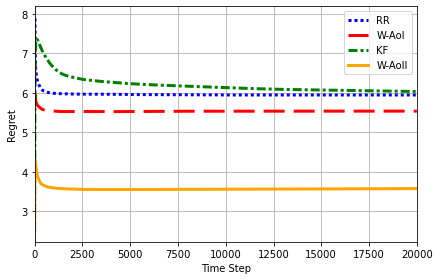

In [55]:
# Plot the regret over time with improved visibility for W-AoI
plt.figure(figsize=(6, 4))
plt.plot(range(len(regret_rr)), regret_rr, label='RR', linestyle=(0, (1, 1)), linewidth=3, color='blue')  # Dotted Line
plt.plot(range(len(regret_waoi)), regret_waoi, label='W-AoI', linestyle=(0, (7, 3)), linewidth=3, color='red')  # Larger dashed line
plt.plot(range(len(regret_kalman)), regret_kalman, label='KF', linestyle=(0, (3, 1, 1, 1)), linewidth=3, color='green')  # Dash-dot-dot
plt.plot(range(len(regret_waoii)), regret_waoii, label='W-AoII', linestyle='solid', linewidth=3, color='orange')  # Solid Line

# Additional plot settings
plt.xlabel('Time Step')
plt.ylabel('Regret')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 20000)
# Show the plot
plt.show()

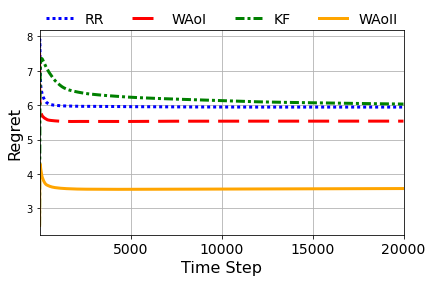

In [56]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(6, 4))

# Plot regret over time with colors, line styles, and markers
plt.plot(range(len(regret_rr)), regret_rr, linestyle=(0, (1, 1)), linewidth=3, color='blue', label='RR')      # Dotted line
plt.plot(range(len(regret_waoi)), regret_waoi, linestyle=(0, (7, 3)), linewidth=3, color='red', label='WAoI')     # Dashed line
plt.plot(range(len(regret_kalman)), regret_kalman, linestyle=(0, (3, 1, 1, 1)), linewidth=3, color='green', label='KF')  # Dash-dot-dot
plt.plot(range(len(regret_waoii)), regret_waoii, linestyle='solid', linewidth=3, color='orange', label='WAoII')  # Solid line

# Set axis labels
plt.xlabel("Time Step", fontsize=16)
plt.ylabel("Regret", fontsize=16)

# Adjust legend placement
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=14, frameon=False)

# Enable grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Set x-axis limits and ticks to display at steps of 5000, 10000, 15000, and 20000
plt.xlim(0, 20000)
plt.xticks([5000, 10000, 15000, 20000], fontsize=14)

# Show the plot
plt.show()

